In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

tda = pd.read_csv("train/train_data_ads.csv")#your directory
tdf = pd.read_csv("train/train_data_feeds.csv")




In [2]:
tdf.rename(columns={'u_userId': 'user_id'}, inplace=True)  #change u_userId to user_id for better merging algotithm
tda.rename(columns={'user_id': 'user_id'}, inplace=True)  

tda = tda.sample(frac= 0.001)#remove this row in real process
tdf = tdf.sample(frac= 0.001)#remove this row in real process

In [3]:
tda['pt_d']

6812569    202206090648
483860     202206030421
3517820    202206060545
7663457    202206090318
486588     202206030841
               ...     
7291423    202206090501
2521928    202206050713
4004518    202206060903
3082319    202206051047
5686370    202206080330
Name: pt_d, Length: 7676, dtype: int64

In [4]:
tda['pt_d'] = tda['pt_d'].astype(str)

# Extract the month and time
tda['month'] = tda['pt_d'].str[4:6]#only consider month
tda['day'] = tda['pt_d'].str[6:8]#only consider date
tda['hour']= tda['pt_d'].str[8:10]#only consider hour

#tda.drop(columns=['pt_d'], inplace=True)





In [5]:
tda['hour']

6812569    06
483860     04
3517820    05
7663457    03
486588     08
           ..
7291423    05
2521928    07
4004518    09
3082319    10
5686370    03
Name: hour, Length: 7676, dtype: object

In [6]:
tda.drop(["city","device_size"], axis=1, inplace= True)    #city is too specific, keep state instead of city should be good
tdf.drop(['u_browserMode','e_pl','e_et',"i_s_sourceId", "i_entities"], axis=1, inplace= True)#some duplicated information and not useful information(please double check for me)

In [7]:
#merge data by user_id
merged_data = pd.merge(tda, tdf, on='user_id', how='outer')#merge them by user_id

# create a feature indicating if the user clicked on the ad (i.e., userID exists in both datasets)
merged_data['clicked'] = merged_data.apply(lambda row: row['user_id'] in tda['user_id'].values and row['user_id'] in tdf['user_id'].values, axis=1)
merged_data.fillna(0, inplace=True )

merged_data.drop(['user_id','log_id','task_id','adv_id','i_docId'], axis = 1, inplace= True)# some data that I would consider to drop based on their distribution. They are either too biased or not meaningful, you can check the distribution and unique value of these variables

In [8]:

#sparse classes combination for the value that exist less than 4 times
value_frequencies = merged_data["residence"].value_counts()
sparse_classes = value_frequencies[value_frequencies < 4].index
merged_data["residence_combined"] = merged_data["residence"].apply(lambda x: 'Other' if x in sparse_classes else x)


In [9]:
# Split the column into multiple columns(like 23151^231^214^123, I separate this long list to multiple column. I think the numerical number could represent certain category, and after ^ is the subset of this category)
def div_cols(col_name):
    global merged_data
    split_columns = merged_data[col_name].str.split('^', expand=True)
    split_columns.columns = [f'{col_name}_{i+1}' for i in range(split_columns.shape[1])]
    split_columns.fillna(0, inplace=True )   
    
    merged_data= pd.concat([merged_data, split_columns], axis=1)
    merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()] #drop duplicated col
        # Concatenate the new columns with the original DataFrame
    merged_data.drop(col_name, axis = 1, inplace= True)
div_cols("ad_click_list_v001")
div_cols("ad_click_list_v002")
div_cols("ad_click_list_v003")
div_cols("ad_close_list_v001")
div_cols("ad_close_list_v002")
div_cols("ad_close_list_v003")

div_cols("u_newsCatDislike")
div_cols("u_newsCatInterests")
div_cols("u_click_ca2_news")










In [10]:
merged_data.drop(['u_newsCatInterestsST_x','u_newsCatInterestsST_y','u_newsCatInterestsST_y'], axis = 1, inplace= True)


In [11]:
merged_data

,label_x,age,gender,residence,city_rank,series_dev,series_group,emui_dev,device_name,net_type,...,u_newsCatInterests_1,u_newsCatInterests_2,u_newsCatInterests_3,u_newsCatInterests_4,u_newsCatInterests_5,u_click_ca2_news_1,u_click_ca2_news_2,u_click_ca2_news_3,u_click_ca2_news_4,u_click_ca2_news_5
0,0.0,5.0,2.0,32.0,5.0,34.0,7.0,19.0,260.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,5.0,2.0,39.0,5.0,31.0,3.0,20.0,346.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,5.0,2.0,12.0,4.0,19.0,6.0,30.0,228.0,6.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,7.0,2.0,28.0,4.0,30.0,3.0,28.0,278.0,7.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,8.0,2.0,16.0,2.0,34.0,7.0,20.0,137.0,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,216,100,0,220,27,27,100,206,199,10
10318,0.0,3.0,3.0,40.0,2.0,16.0,5.0,20.0,220.0,6.0,...,0,0,0,0,0,0,0,0,0,0
10319,0.0,4.0,2.0,13.0,4.0,17.0,4.0,19.0,130.0,7.0,...,0,0,0,0,0,0,0,0,0,0
10320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,112,112,168,16,203,39,36,144,168,173


In [12]:
def find_value_in_columns(df, value):
    result = {}
    for col in df.columns:
        if df[col].astype(str).str.contains(str(value)).any():
            result[col] = df[df[col].astype(str).str.contains(str(value))][col].unique()
    return result

# Search for the value
search_results = find_value_in_columns(merged_data, '65^0')
search_results

{}

In [13]:
from sklearn.preprocessing import LabelEncoder

target = 'clicked'

encoded_data = merged_data.copy()

# Identify categorical columns
categorical_cols = encoded_data.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)

# Initialize the label encoder
label_encoder = LabelEncoder()

# encode each categorical column
for col in categorical_cols:
    encoded_data[col] = label_encoder.fit_transform(encoded_data[col])



Categorical columns: Index(['pt_d', 'month', 'day', 'hour', 'residence_combined',
       'ad_click_list_v001_1', 'ad_click_list_v001_2', 'ad_click_list_v001_3',
       'ad_click_list_v001_4', 'ad_click_list_v001_5', 'ad_click_list_v002_1',
       'ad_click_list_v002_2', 'ad_click_list_v002_3', 'ad_click_list_v002_4',
       'ad_click_list_v002_5', 'ad_click_list_v003_1', 'ad_click_list_v003_2',
       'ad_click_list_v003_3', 'ad_click_list_v003_4', 'ad_click_list_v003_5',
       'ad_close_list_v001_1', 'ad_close_list_v001_2', 'ad_close_list_v001_3',
       'ad_close_list_v001_4', 'ad_close_list_v001_5', 'ad_close_list_v002_1',
       'ad_close_list_v002_2', 'ad_close_list_v002_3', 'ad_close_list_v002_4',
       'ad_close_list_v002_5', 'ad_close_list_v003_1', 'ad_close_list_v003_2',
       'ad_close_list_v003_3', 'ad_close_list_v003_4', 'ad_close_list_v003_5',
       'u_newsCatDislike_1', 'u_newsCatDislike_2', 'u_newsCatDislike_3',
       'u_newsCatDislike_4', 'u_newsCatDislike_5', 'u_n

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [ ]:
var1 = 'u_phonePrice'
var2 = 'city_rank' 

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_data[var1], y=merged_data[var2])
plt.title(f'Scatter Plot of {var1} vs. {var2}')
plt.xlabel(var1)
plt.ylabel(var2)
plt.show()

# Correlation coefficient
correlation = merged_data[var1].corr(merged_data[var2])
print(f'Correlation coefficient between {var1} and {var2}: {correlation}')

In [14]:
corr_matrix = encoded_data.corr()

target_corr = corr_matrix[target].sort_values(ascending=False)

significant_corr = target_corr[abs(target_corr) > 0.1]
significant_corr

ValueError: could not convert string to float: 'Other'

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [18]:
target = 'clicked'  #the value that i want to predict

# Identify features and target
X = merged_data.drop(columns=[target])
y = merged_data[target]

# Convert all categorical columns to string type to ensure consistency
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [20]:

# Identify columns that need log transformation
log_transform_cols = ['pro','e_section','e_rn','e_po','i_cat','i_dislikeTimes','e_m','i_upTimes']  # these value are heavily skewed, so i perform a log transformation

non_log_transform_cols = [col for col in numerical_cols if col not in log_transform_cols]

# Define a log transformation function
def log_transform(x):
    return np.log1p(x)

# Preprocessing for numerical data:log transform, and scale
log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform, validate=True)),
    ('scaler', StandardScaler())
])

# Preprocessing for numerical data that does not require log transform: scale
non_log_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data: impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('log_num', log_transformer, log_transform_cols),
        ('non_log_num', non_log_transformer, non_log_transform_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


merged_data.to_csv('train/synthetic_data.csv', index=False)


Model: Logistic Regression
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC AUC Score: 1.00


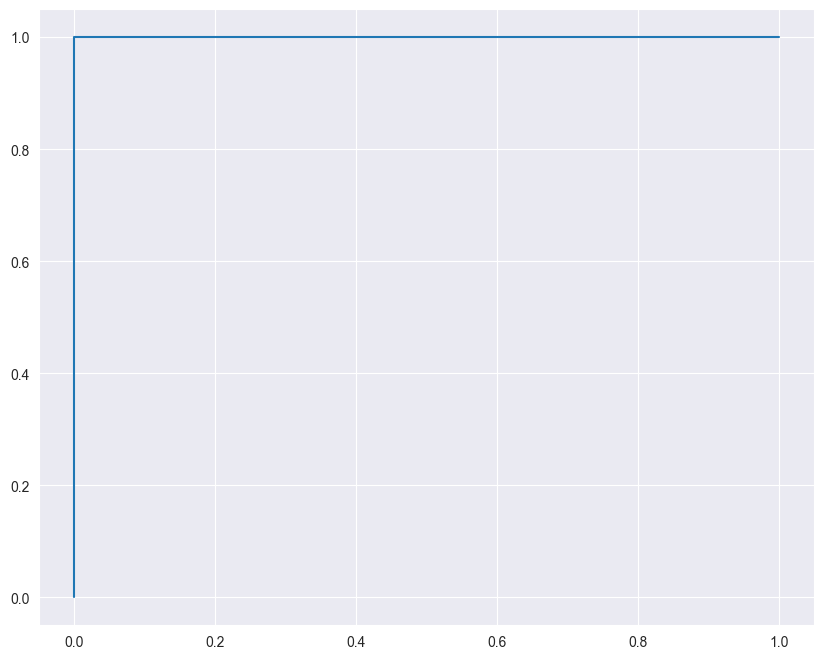

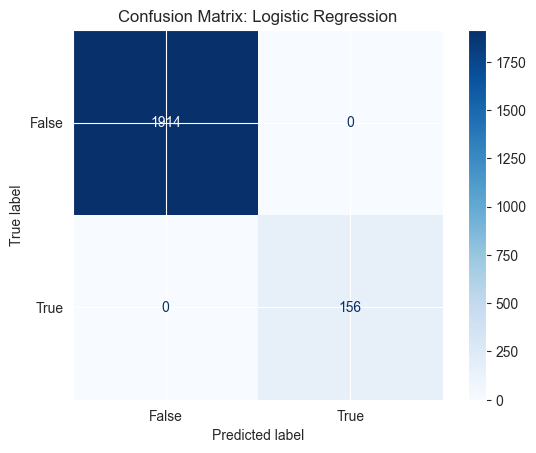

Model: Decision Tree
Accuracy: 1.00
Precision: 1.00
Recall: 0.98
F1-Score: 0.99
ROC AUC Score: 0.99


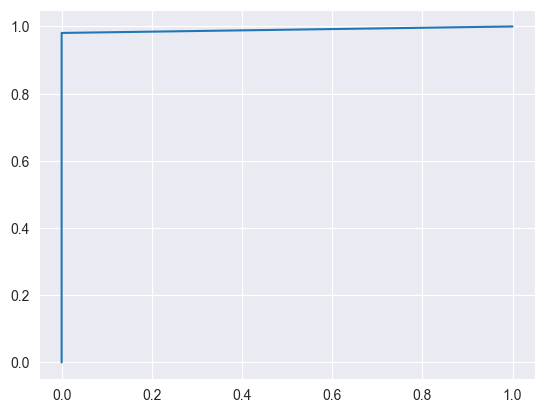

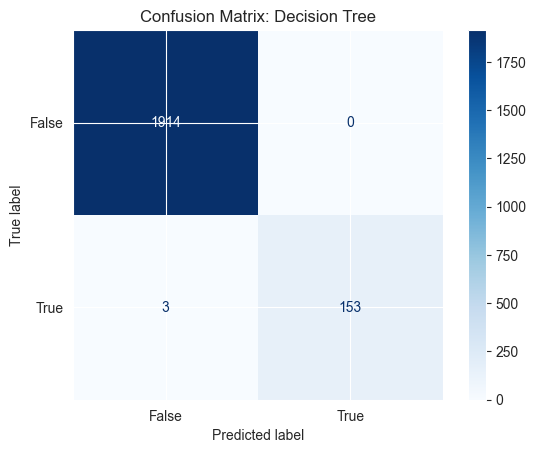

Model: Random Forest
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC AUC Score: 1.00


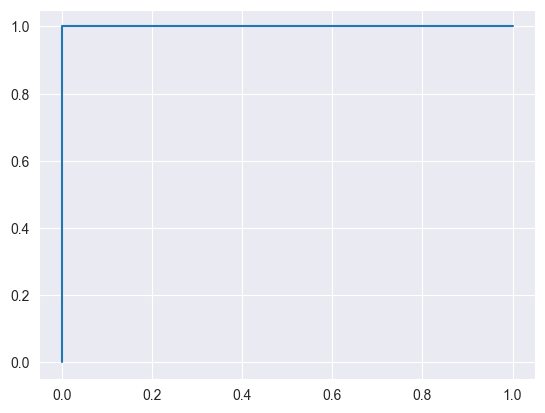

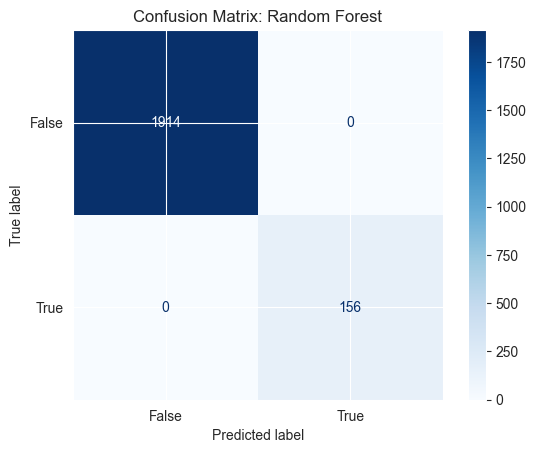

Model: SVM
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC AUC Score: 1.00


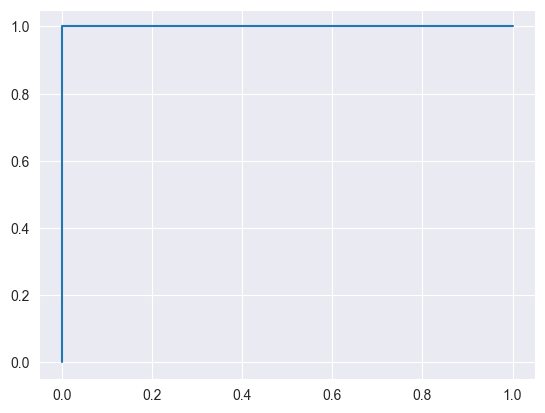

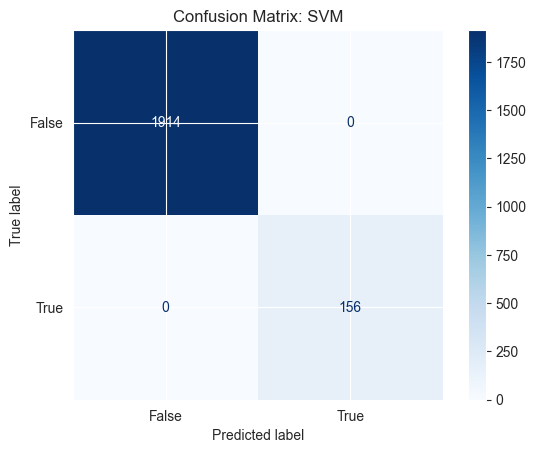

Model: Gradient Boosting
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC AUC Score: 1.00


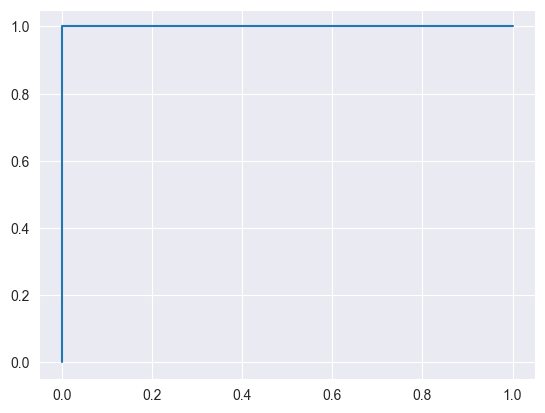

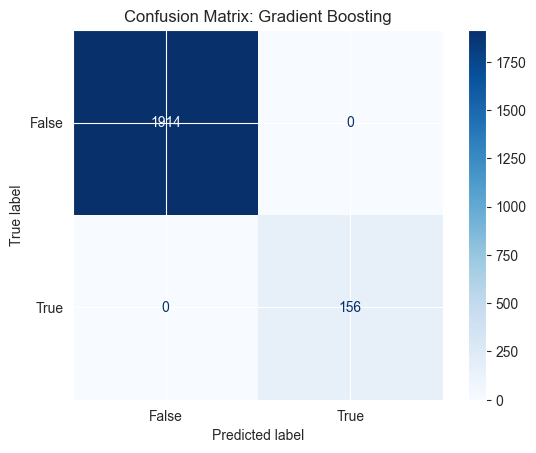

/var/folders/c_/nnwmqx6x7kld8hm41zxgpc2w0000gn/T/ipykernel_13387/1957291279.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


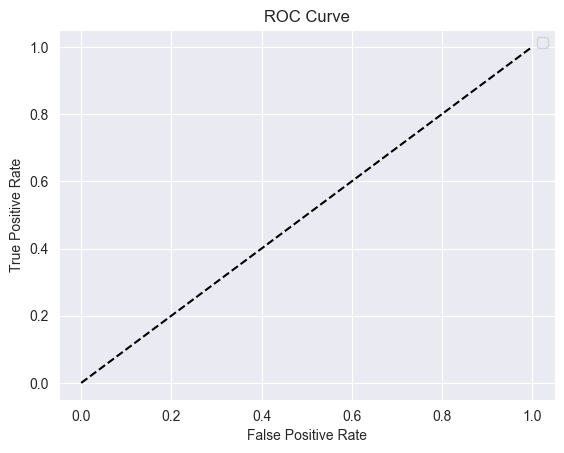

In [66]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    if roc_auc is not None:
        print(f"ROC AUC Score: {roc_auc:.2f}")
    
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# Initialize a list to store models and their names
models = []
model_names = []


# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])
log_reg.fit(X_train, y_train)
models.append(log_reg)
model_names.append("Logistic Regression")

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
tree = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', DecisionTreeClassifier())])
tree.fit(X_train, y_train)
models.append(tree)
model_names.append("Decision Tree")

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier())])
forest.fit(X_train, y_train)
models.append(forest)
model_names.append("Random Forest")

# Support Vector Machine (SVM)
from sklearn.svm import SVC
svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(probability=True))])
svm.fit(X_train, y_train)
models.append(svm)
model_names.append("SVM")

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', GradientBoostingClassifier())])
gb.fit(X_train, y_train)
models.append(gb)
model_names.append("Gradient Boosting")

# Step 3: Evaluate and Compare Models

plt.figure(figsize=(10, 8))
for model, name in zip(models, model_names):
    evaluate_model(model, X_test, y_test, name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [3]:


# Age Group Distribution
age_groups = pd.cut(merged_data['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+'])
age_distribution = merged_data[merged_data['clicked'] == True].groupby(age_groups).size()
print("Age Group Distribution:\n", age_distribution)

# Geographic Distribution
geo_distribution = merged_data[merged_data['clicked'] == True].groupby('residence').size().sort_values(ascending=False)
print("\nGeographic Distribution:\n", geo_distribution)

# Device Usage
device_usage = merged_data[merged_data['clicked'] == True].groupby('device').size().sort_values(ascending=False)
print("\nDevice Usage:\n", device_usage)

# Engagement Patterns

hourly_engagement = merged_data[merged_data['clicked'] == True].groupby('hour').size()
daily_engagement = merged_data[merged_data['clicked'] == True].groupby('day').size()
print("\nHourly Engagement Patterns:\n", hourly_engagement)
print("\nDaily Engagement Patterns:\n", daily_engagement)

# Content Preferences
content_preferences = merged_data[merged_data['clicked'] == True].groupby('content_type').size().sort_values(ascending=False)
print("\nContent Preferences:\n", content_preferences)

# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

# Age Group Distribution Plot
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Age Group Distribution of Users Who Click on Ads')
plt.xlabel('Age Group')
plt.ylabel('Number of Clicks')
plt.show()

# Geographic Distribution Plot
plt.figure(figsize=(10, 6))
geo_distribution.head(10).plot(kind='bar')
plt.title('Top 10 Locations of Users Who Click on Ads')
plt.xlabel('Location')
plt.ylabel('Number of Clicks')
plt.show()

# Device Usage Plot
plt.figure(figsize=(10, 6))
device_usage.plot(kind='bar')
plt.title('Device Usage of Users Who Click on Ads')
plt.xlabel('Device')
plt.ylabel('Number of Clicks')
plt.show()

# Hourly Engagement Patterns Plot
plt.figure(figsize=(10, 6))
hourly_engagement.plot(kind='bar')
plt.title('Hourly Engagement Patterns of Users Who Click on Ads')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Clicks')
plt.show()

# Daily Engagement Patterns Plot
plt.figure(figsize=(10, 6))
daily_engagement.plot(kind='bar')
plt.title('Daily Engagement Patterns of Users Who Click on Ads')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Clicks')
plt.show()

# Content Preferences Plot
plt.figure(figsize=(10, 6))
content_preferences.plot(kind='bar')
plt.title('Content Preferences of Users Who Click on Ads')
plt.xlabel('Content Type')
plt.ylabel('Number of Clicks')
plt.show()


NameError: name 'merged_data' is not defined